# Aufgabe

In [76]:
PDF("Data_Challenge_Aktuariat.pdf", size=(800, 800))

# Imports

In [74]:
# Basics
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats as stats

# Plotting/visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.graphics.regressionplots import abline_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import GammaRegressor
from sklearn import metrics


import visualization_helper as vis
import importlib
importlib.reload(vis)

import logging
import sys
logging.basicConfig(stream=sys.stdout)

# Hilfsfunktionen

## Statistik

In [64]:
# ANOVA Test
def calculate_nested_f_statistic(small_model, big_model):
    """Given two fitted GLMs, the larger of which contains the parameter space of the smaller, return the F Stat and P value corresponding to the larger model adding explanatory power"""
    addtl_params = big_model.df_model - small_model.df_model
    f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)
    df_numerator = addtl_params
    # use fitted values to obtain n_obs from model object:
    df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
    p_value = stats.f.sf(f_stat, df_numerator, df_denom)
    return (f_stat, p_value)

In [65]:
def bootstrap_model(data, callable_model, resamples=100):
    """Collection of bootstrap models fitted according to formula"""
    bootstrap_models = []
    for i in range(resamples):
        resample = data.sample(len(data), replace=True)
        bootstrap_models.append(callable_model(resample).fit())

    return bootstrap_models
        

In [66]:
def bootstrap_gof_poisson():
    pass

In [67]:
def get_bootstrap_spread(fitted_model_coll, x_data, conf_alpha):
    model_predictions = np.array([model.predict(x_data) for model in fitted_model_coll])
    upper = np.array([np.max(model_predictions[:, i]) for i in range(len(x_data))])
    lower = np.array([np.min(model_predictions[:, i]) for i in range(len(x_data))])
    return (lower, upper)

## Visualisierung

In [63]:
# Helper class for embedding PDF files into notebook
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

In [62]:
def scatterplot_all(df, target, ncols=3, figsize=(15, 12), alpha=0.1):
    
    # Get all features to plot against target
    features = df.columns.drop(target)

    colors = ['#0055ff', '#ff7000', '#23bf00']
    sns.set_palette(sns.color_palette(colors))

    # Calculate required rows
    nrows = int(np.ceil(len(features) / 3))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=200)

    # Ensure that ax is 2D
    if nrows == 1:
        ax = ax.reshape(-1, 1)

    for i in range(len(features)):
        x = i//ncols
        y = i % ncols

        sns.scatterplot(data=df, x=features[i], y=target, ax=ax[x, y], alpha=alpha)
        ax[x, y].set_title('{} vs. {}'.format(target, features[i]), size=15)
        ax[x, y].set_xlabel(features[i], size=12)
        ax[x, y].set_ylabel(target, size=12)
        ax[x, y].grid()

    return ax

# Datenexploration

## Aufbereitung

Die CSV-Daten werden zunächst zur einfacheren Manipulation
in eine SQLite-Datenbank mit der folgenden Struktur überführt:

``` mysql
CREATE TABLE FREMTPL2FREQ (
    IDpol      INTEGER PRIMARY KEY,
    ClaimNb    INTEGER,
    Exposure   NUMERIC,
    Area       TEXT,
    VehPower   NUMERIC,
    VehAge     INTEGER,
    DrivAge    INTEGER,
    BonusMalus NUMERIC,
    VehBrand   TEXT,
    VehGas     TEXT,
    Density    NUMERIC,
    Region     TEXT
);

CREATE TABLE FREMTPL2SEV (
    IDpol       INTEGER,
    ClaimAmount NUMERIC
);
```

<div class="alert alert-block alert-danger">
<b>Notiz:</b> *Notiz: `FREMTPL2SEV.IDpol` ist weder PRIMARY KEY (nicht eindeutig) noch FOREIGN KEY (es existieren `FREMTPL2SEV.IDpol` ohne zugehörige Police-Merkmale in `FREMTPL2SEV.IDpol`*)
</div>

**Auffälligkeiten:**
1. Es gibt 195 Datensätze in Tabelle ```FREMTPL2SEV```, zu denen keine Tarifmerkmale in ```FREMTPL2FREQ``` vorliegen. Diese sind für die Modellierung wertlos und werden verworfen.
2. Es gibt 9116 Datensätze (von 679513) ~ 1,3%, für die mindestens ein Schadensfall eingetreten ist, allerdings keine Schadenshöhen bekannt sind.
$\Rightarrow$ Interpretation: Datensätze sind nicht fehlerhaft, es fehlt schlicht Information. Die Daten können also für die Modellierung von ClaimNb herangezogen werden, allerdings nicht für ClaimAmount.
``` mysql
SELECT *
FROM FREMTPL2FREQ
LEFT JOIN FREMTPL2SEV
ON FREMTPL2FREQ.IDpol = FREMTPL2SEV.IDpol
WHERE ClaimNb > 1 AND FREMTPL2SEV.IDpol IS NULL
```
    returned 9116 rows

**Aufbereitung der Daten:**
1. Schadenshöhen für Datensätze mit 0 Schadensfällen werden auf 0 gesetzt
2. Datensätze zu Policen mit mehreren Schadensfällen werden zu einem Datensatz zusammengefasst, in dem sowohl Gesamtschaden als auch durchschnittlicher Schaden geführt werden

In [5]:
# Connect to SQLite DB
with sqlite3.connect("../raw data/TestDB") as con:

    # SQL query to select fully informative rows (ClaimNb, ClaimAmount, policy data is known)
    qry = """SELECT ClaimNb, Exposure,
    ClaimNb / Exposure AS ClaimFreq,
    Area, VehPower, VehAge, DrivAge, BonusMalus, VehBrand, VehGas, Density, Region,
    SUM(COALESCE(ClaimAmount, 0)) AS TotalClaimAmount,
    AVG(COALESCE(ClaimAmount, 0)) AS AvgClaimAmount
    FROM FREMTPL2FREQ
    LEFT JOIN FREMTPL2SEV
    ON IDpol = IDpol2
    WHERE ClaimNb = 0 OR IDpol2 IS NOT NULL
    GROUP BY IDpol"""

    # Execute SQL query and cast query table into Pandas DataFrame
    df = pd.read_sql_query(qry, con)

In [84]:
df.head(5)

,ClaimNb,Exposure,ClaimFreq,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,TotalClaimAmount,AvgClaimAmount
0,1,0.75,1.333333,'F',7,1,61,50,'B12','Regular',27000,'R11',303.00,303.00
1,1,0.14,7.142857,'B',12,5,50,60,'B12','Diesel',56,'R25',1981.84,1981.84
2,1,0.14,7.142857,'E',4,0,36,85,'B12','Regular',4792,'R11',1456.55,1456.55
3,2,0.62,3.225806,'F',10,0,51,100,'B12','Regular',27000,'R11',10834.00,5417.00
4,1,0.31,3.225806,'A',5,0,45,50,'B12','Regular',12,'R73',3986.67,3986.67


In [476]:
# Discretize some numerical data
cat_veh_age = pd.cut(df['VehAge'], bins=[0, 2, 10, 25, 100], include_lowest=True, labels=['new', 'mid', 'mid_old', 'old'])
df.insert(6, "CatVehAge", cat_veh_age, allow_duplicates=False)
df

,ClaimNb,Exposure,ClaimFreq,Area,VehPower,VehAge,CatVehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,TotalClaimAmount,AvgClaimAmount
0,1,0.75000,1.333333,'F',7,1,new,61,50,'B12','Regular',27000,'R11',303.00,303.00
1,1,0.14000,7.142857,'B',12,5,mid,50,60,'B12','Diesel',56,'R25',1981.84,1981.84
2,1,0.14000,7.142857,'E',4,0,new,36,85,'B12','Regular',4792,'R11',1456.55,1456.55
3,2,0.62000,3.225806,'F',10,0,new,51,100,'B12','Regular',27000,'R11',10834.00,5417.00
4,1,0.31000,3.225806,'A',5,0,new,45,50,'B12','Regular',12,'R73',3986.67,3986.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668892,0,0.00274,0.000000,'E',4,0,new,54,50,'B12','Regular',3317,'R93',0.00,0.00
668893,0,0.00274,0.000000,'E',4,0,new,41,95,'B12','Regular',9850,'R11',0.00,0.00
668894,0,0.00274,0.000000,'D',6,2,new,45,50,'B12','Diesel',1323,'R82',0.00,0.00
668895,0,0.00274,0.000000,'B',4,0,new,60,50,'B12','Regular',95,'R26',0.00,0.00


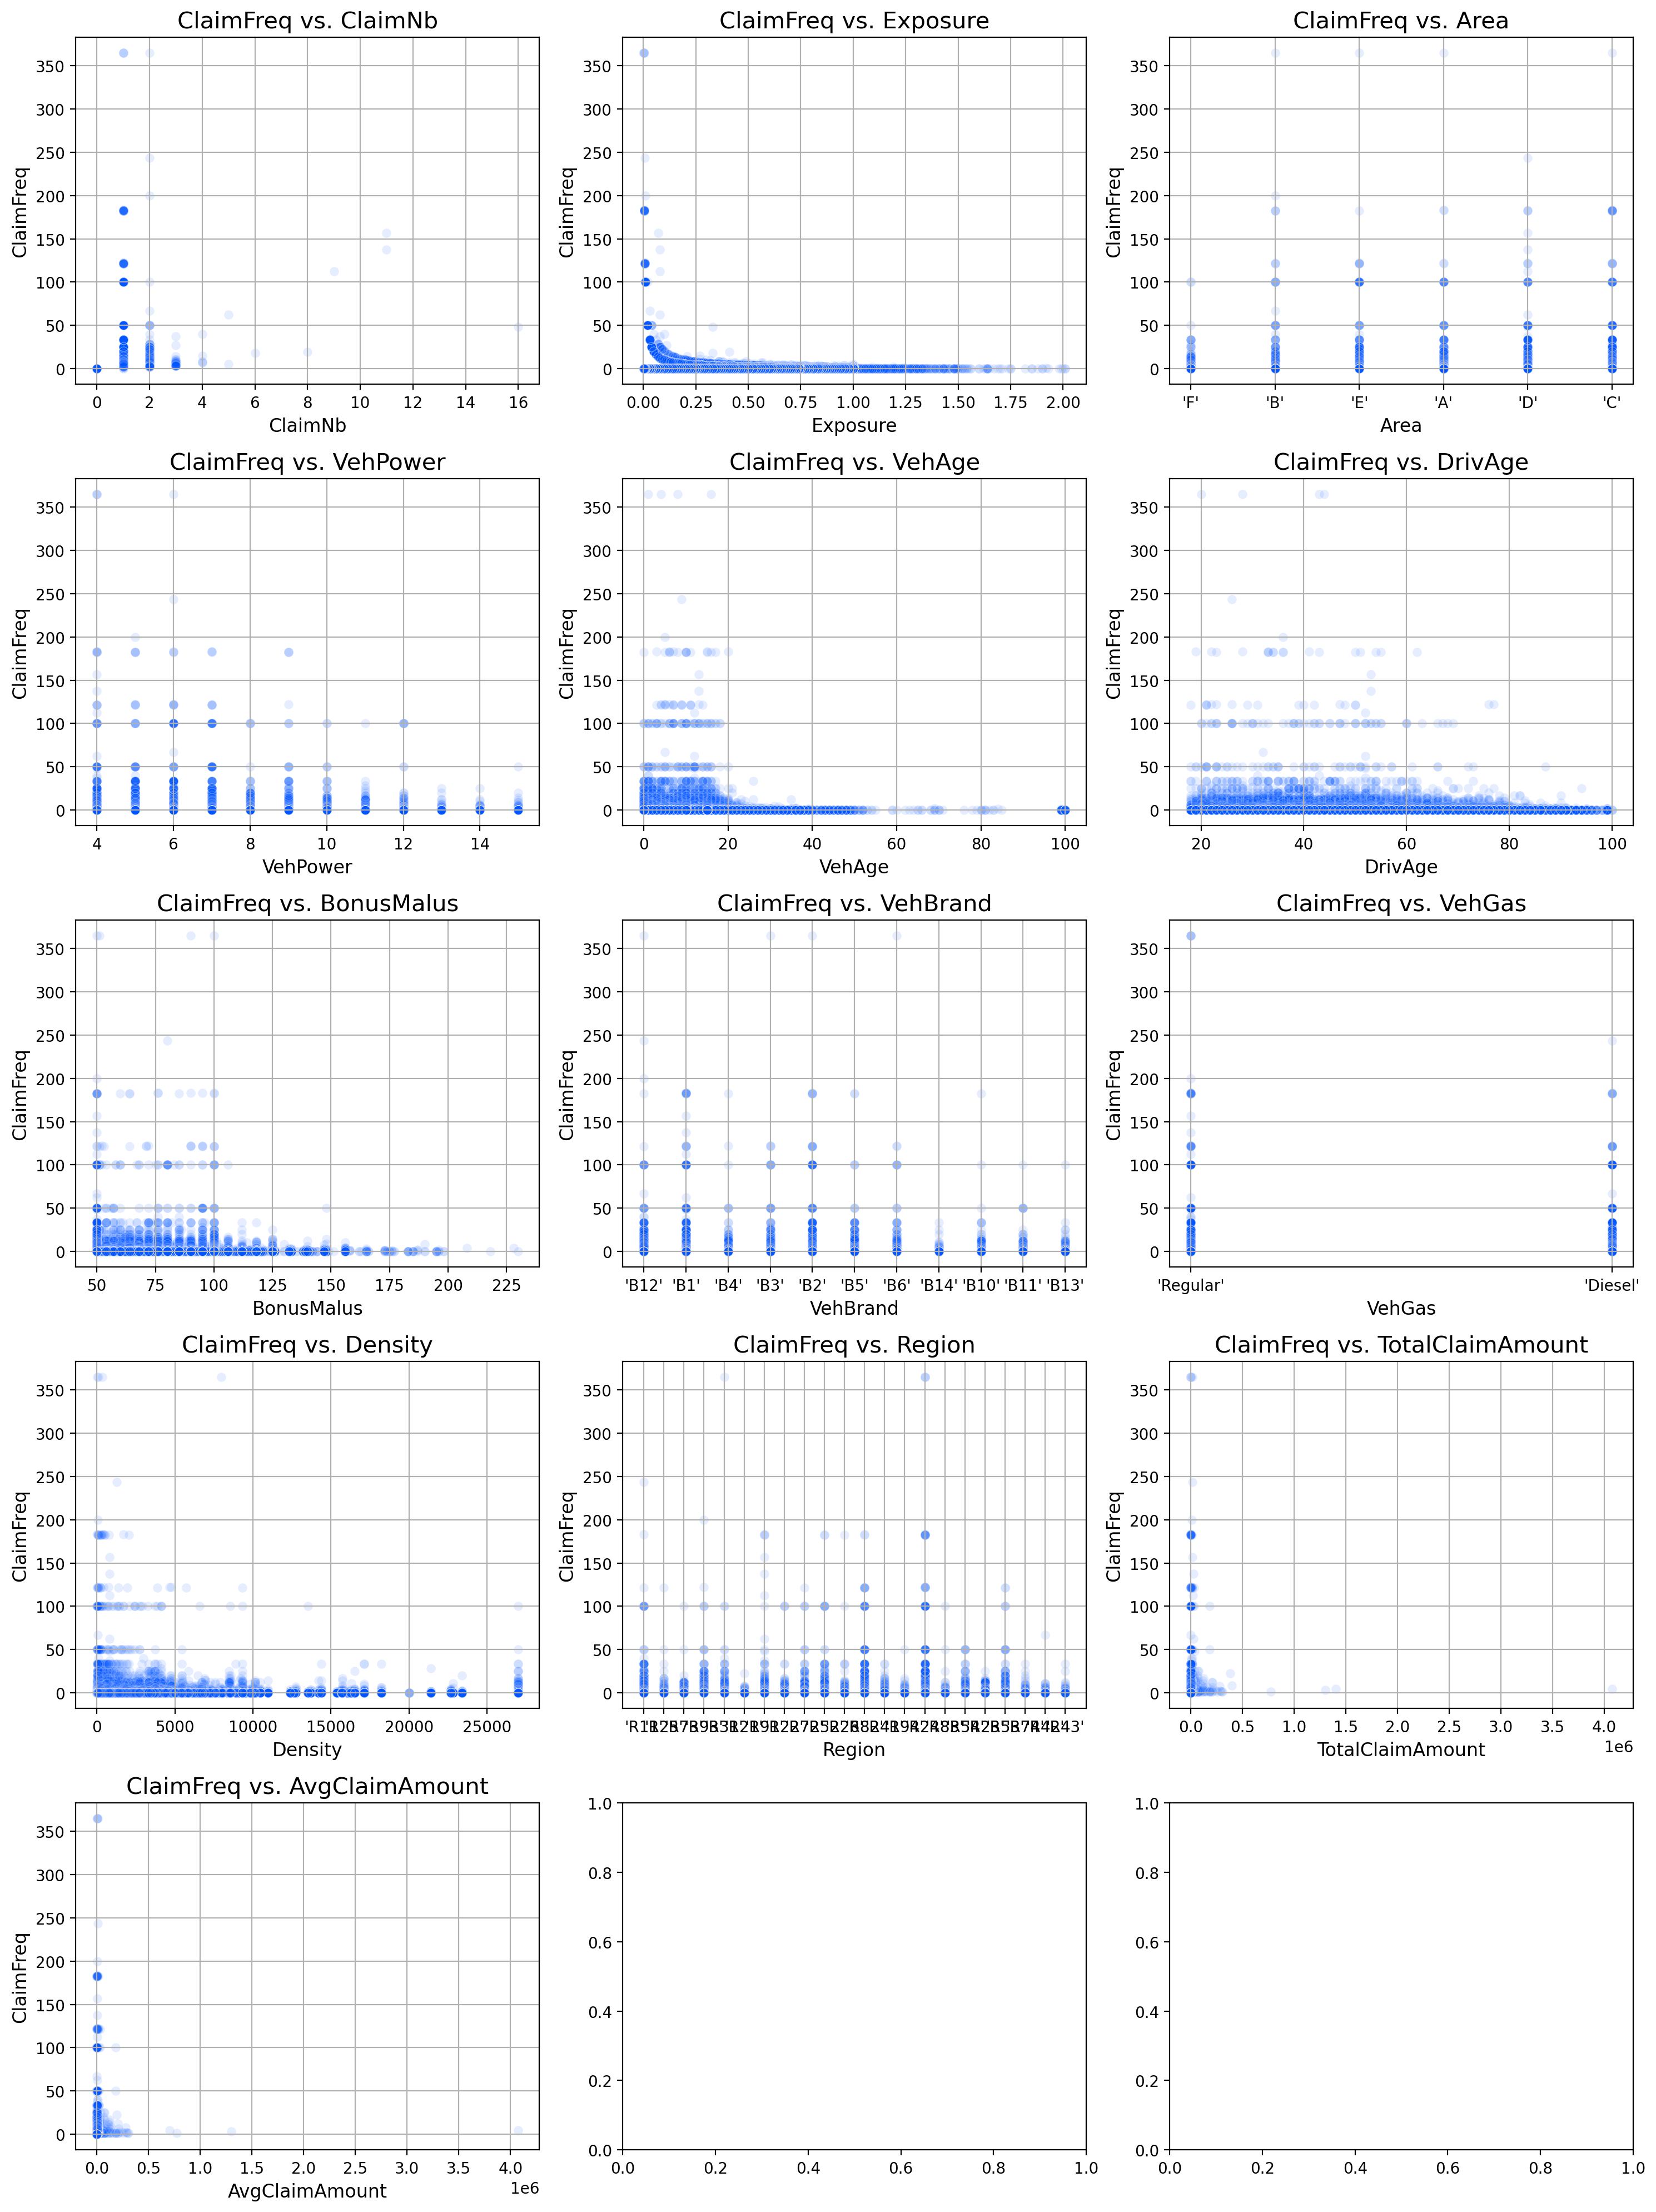

In [233]:
ax = vis.scatterplot_all(df, "ClaimFreq", figsize=(15, 20))
#for elem in ax.flatten(): elem.set_ylim([0, 50000])
plt.tight_layout()
plt.show()

<Axes: xlabel='DrivAge', ylabel='AvgClaimAmount'>

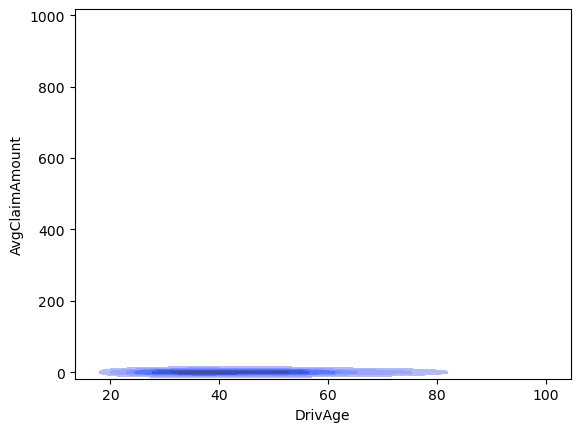

In [215]:
data = df[df["AvgClaimAmount"] < 1000]

sns.kdeplot(x=data["DrivAge"], y=data["AvgClaimAmount"], fill=True)
plt.show()

# Test auf Poisson-Verteilung für ClaimNb

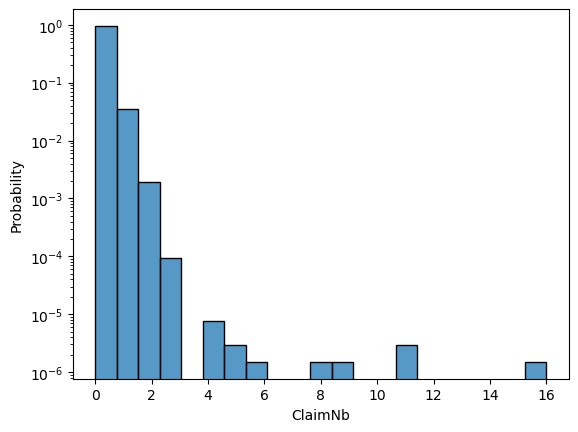

In [55]:
sns.histplot(data=df, x="ClaimNb", stat="probability")
sns.plot()
ax = plt.gca()
plt.yscale("log")
sns.lineplot(data=may_flights, x="year", y="passengers")
plt.show()

In [59]:
# Test for Poisson-ness
test = df[df["ClaimNb"] < 5]
print("mle_mean: {}, mle_var: {}".format(str(np.mean(test["ClaimNb"])), str(np.var(test["ClaimNb"]))))

mle_mean: 0.03942956155655124, mle_var: 0.04240477081124886


In [56]:
df.to_csv('out.csv', index=False)

# Modellanpassung für ClaimNb

In [6]:
# Train-test-split
train, test = train_test_split(df, test_size=0.3, random_state=17)

In [486]:
# Select features
X_train_freq = train[["BonusMalus"]]

# Select target
y_train_freq = train["ClaimFreq"]

X_train_freq.head(5)

,BonusMalus
31758,50
245603,50
588987,50
297069,50
366788,51


In [488]:
poisson_glm = PoissonRegressor()
poisson_glm.fit(X_train_freq, y_train_freq)

poisson_glm.score(X_train_freq, y_train_freq)

0.022290992500376028

In [7]:
formula = "ClaimNb ~ BonusMalus"
formula_big = "ClaimNb ~ BonusMalus"

glm_poisson = smf.glm(formula=formula, data=train, offset=np.log(train["Exposure"]), family=sm.families.Poisson())
res_poisson = glm_poisson.fit()

glm_poisson_big = smf.glm(formula=formula_big, data=train, offset=np.log(train["Exposure"]), family=sm.families.Poisson())
res_poisson_big = glm_poisson_big.fit()

f_stat, p_value = calculate_nested_f_statistic(res_poisson, res_poisson_big)
print(f_stat, p_value)

print(res_poisson.summary())
print(res_poisson_big.summary())
aic = res_poisson.aic
resid = np.abs(res_poisson.resid_response)

C:\Users\marva\AppData\Local\Temp\ipykernel_1660\2456296977.py:4: RuntimeWarning: invalid value encountered in scalar divide
  f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)


nan nan
                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               468227
Model:                            GLM   Df Residuals:                   468225
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -76387.
Date:                Sun, 29 Sep 2024   Deviance:                   1.1688e+05
Time:                        23:48:56   Pearson chi2:                 8.62e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.008271
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0951      0.024   -169.478 

In [8]:
callable = lambda dataset: smf.glm(formula=formula, data=dataset, offset=np.log(dataset["Exposure"]), family=sm.families.Poisson())

In [9]:
bootstrap = bootstrap_confidence(train, callable, resamples=100)

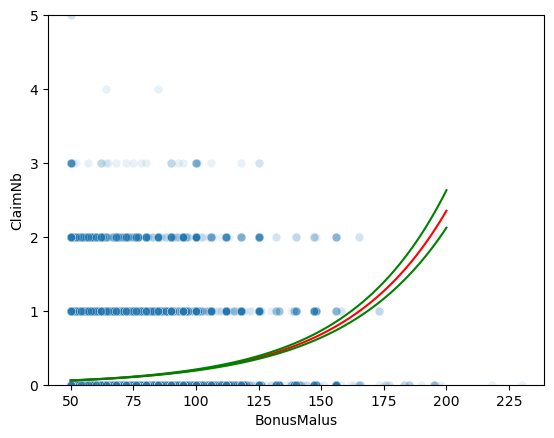

In [10]:
x_plot_data = np.linspace(50, 200, 100)
x_data = pd.DataFrame(dict(BonusMalus=x_plot_data))
lower, upper = get_confidence_bands(bootstrap, x_data, 0.9)

y_pred_sm = res_poisson.predict(exog=x_data)
sns.scatterplot(data=train, x="BonusMalus", y="ClaimNb", alpha=0.1)
ax = plt.gca()
ax.set_ylim([0, 5])
plt.plot(x_plot_data, y_pred_sm, color="red")
plt.plot(x_plot_data, upper, color="green")
plt.plot(x_plot_data, lower, color="green")
plt.show()

In [663]:
# Check for Poisson distribution
predicted_claim_nb = res_poisson.predict(train)
mle = np.mean(predicted_claim_nb)

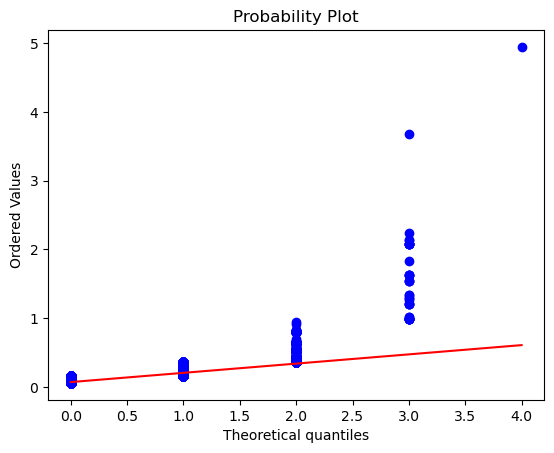

In [452]:
fig = plt.figure()
ax = plt.gca()
stats.probplot(predicted_claim_nb, dist=stats.poisson(mle), plot=ax)
plt.show()

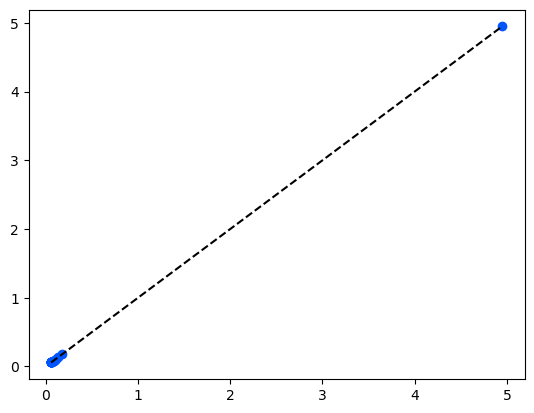

In [386]:
percs = np.linspace(0, 100, 21)
qn_a = np.percentile(predicted_claim_nb, percs)
qn_b = np.percentile(predicted_claim_nb, percs)

plt.plot(qn_a,qn_b, ls="", marker="o")

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
plt.plot(x,x, color="k", ls="--")

plt.show()

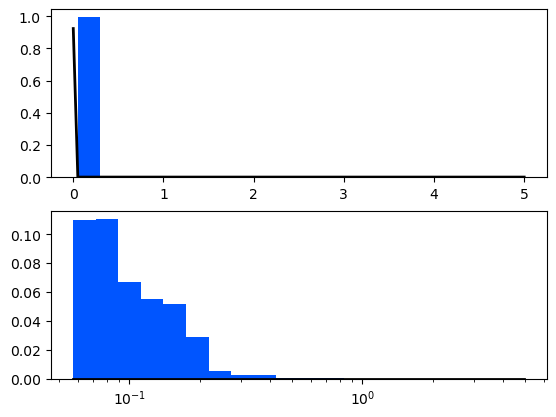

In [382]:
# Plot the histogram.
# histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(predicted_claim_nb, weights=np.zeros_like(predicted_claim_nb) + 1. / len(predicted_claim_nb), bins=20)
x = np.linspace(0, 5, 100)
p = stats.poisson.pmf(x, mle)

plt.plot(x, p, 'k', linewidth=2)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(predicted_claim_nb, weights=np.zeros_like(predicted_claim_nb) + 1. / len(predicted_claim_nb), bins=logbins)
p_log = stats.poisson.pmf(logbins, mle)

plt.plot(logbins, p_log, 'k', linewidth=2)
plt.xscale('log')
plt.show()

In [378]:
logbins

array([0.0574245 , 0.07175666, 0.08966589, 0.11204494, 0.14000942,
       0.17495336, 0.2186187 , 0.27318215, 0.34136369, 0.42656217,
       0.53302472, 0.66605849, 0.83229518, 1.04002169, 1.29959314,
       1.62394914, 2.02925879, 2.53572674, 3.16860034, 3.95942825,
       4.94763316])

In [526]:
tempdf = pd.DataFrame(dict(CatVehAge=x_plot_data))
cat_veh_age = pd.cut(tempdf['CatVehAge'], bins=[0, 2, 10, 25, 100], include_lowest=True, labels=['new', 'mid', 'mid_old', 'old'])
cat_veh_age

0     new
1     new
2     mid
3     mid
4     mid
     ... 
95    old
96    old
97    old
98    old
99    old
Name: CatVehAge, Length: 100, dtype: category
Categories (4, object): ['new' < 'mid' < 'mid_old' < 'old']

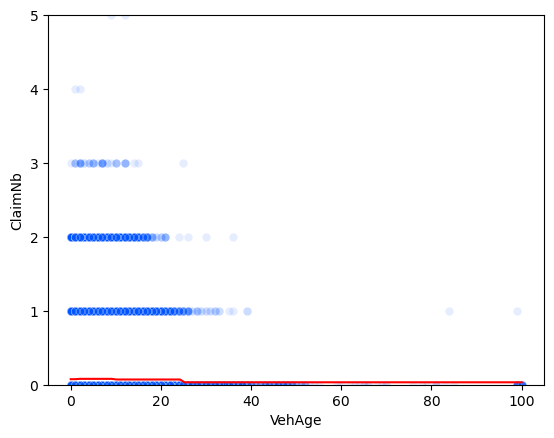

In [528]:
#x_plot_data = np.linspace(0, 100, 100)

#y_pred = poisson_glm.predict(x_plot_data.reshape(-1, 1))
y_pred_sm = res_poisson.predict(exog=cat_veh_age)
sns.scatterplot(data=train, x="VehAge", y="ClaimNb", alpha=0.1)
ax = plt.gca()
ax.set_ylim([0, 5])
plt.plot(x_plot_data, y_pred_sm, color="red")
plt.show()

In [213]:
df_claimNb_not_zero = df[df["ClaimNb"] > 0]

X = df_claimNb_not_zero[["DrivAge"]]

# Select target
y_claim_sev = df_claimNb_not_zero["AvgClaimAmount"]

# Split into test and training sets
X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(X, y_claim_sev, test_size=0.01, random_state=0)
X_train_sev.head(5)

,DrivAge
450291,50
150025,35
600084,28
22,51
263421,52


In [247]:
# sklearn GLM
gamma_glm = GammaRegressor()
gamma_glm.fit(X_train_sev, y_train_sev)

gamma_glm.score(X_train_sev, y_train_sev)

0.018747612923381007

In [255]:
# statsmodels GLM
formula = "AvgClaimAmount ~ DrivAge"
glm_gamma = smf.glm(formula=formula, data=df_claimNb_not_zero, family=sm.families.Gamma(link=sm.families.links.Log()))

res_gamma = glm_gamma.fit()
#print(res_gamma.summary())

y_pred = res_gamma.predict(exog=dict(DrivAge=df_claimNb_not_zero["DrivAge"]))
metrics.r2_score(df_claimNb_not_zero["AvgClaimAmount"], y_pred)

0.0002850138429812965

In [343]:
# statsmodels GAM

# create spline basis for weight and hp
x_spline = df_claimNb_not_zero[["DrivAge", "VehAge"]]

bs = BSplines(x_spline, df=[15, 15], degree=[3, 3])

gam_bs = GLMGam.from_formula('AvgClaimAmount ~ BonusMalus + C(VehBrand) + C(Area)', data=df_claimNb_not_zero, smoother=bs, family=sm.families.Gamma(link=sm.families.links.Log()))
res_bs = gam_bs.fit()

print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         AvgClaimAmount   No. Observations:                24944
Model:                         GLMGam   Df Residuals:                 24898.74
Model Family:                   Gamma   Df Model:                        44.26
Link Function:                    Log   Scale:                          18.924
Method:                         PIRLS   Log-Likelihood:            -2.4982e+05
Date:                Fri, 27 Sep 2024   Deviance:                       37233.
Time:                        20:28:57   Pearson chi2:                 4.71e+05
No. Iterations:                   105   Pseudo R-squ. (CS):            0.01096
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.7489 

In [267]:
x_plot_data = np.linspace(18, 100, 100)

y_pred_sklearn = gamma_glm.predict(x_plot_data.reshape(-1, 1))
y_pred_sm = res_gamma.predict(exog=dict(DrivAge=x_plot_data))
y_pred_gam = res_bsv.predict(exog=dict(DrivAge=x_plot_data))

sns.scatterplot(data=df_claimNb_not_zero, x="DrivAge", y="AvgClaimAmount", alpha=0.5)
ax = plt.gca()
ax.set_ylim([0, 3000])
plt.plot(x_plot_data, y_pred_sklearn, color="red")
plt.plot(x_plot_data, y_pred_sm, color="green")
plt.plot(x_plot_data, y_pred_sm, color="green")
plt.show()

C:\Users\marva\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GammaRegressor was fitted with feature names
  warnings.warn(


ValueError: shapes (100,2) and (13,) not aligned: 2 (dim 1) != 13 (dim 0)

In [186]:
y_pred_sklearn

0     1827.034604
1     1858.612793
2     1890.736774
3     1923.415982
4     1956.660012
         ...     
95    9305.740596
96    9466.579605
97    9630.198531
98    9796.645422
99    9965.969156
Length: 100, dtype: float64

In [4]:
# Poisson distribution looks pretty good! Do more rigorous GOF test
# Then fit conditional expectations

# Is exposure also poisson distributed?

# mu_mle = np.mean(df["EstimatedClaimFreq"])
# k = 0
# print("Empirical: {}, fitted: {}".format(len(df[df["EstimatedClaimFreq"] == k])/len(df), scipy.stats.poisson.pmf(k, mu_mle)))

KeyError: 'EstimatedClaimFreq'